In [110]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam
import monai
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor



# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator




# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import SamModel, SamProcessor



2.6.0+cu126
True


## Gather data for each split

In [111]:
importlib.reload(image_mask_dataset)
importlib.reload(model_evaluator)

# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-large")

# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test", processor)
train_dataset = ImageMaskDataset(dataset_path, "train", processor)
valid_dataset = ImageMaskDataset(dataset_path, "valid", processor)

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 156/156 [00:00<00:00, 9184.87it/s]


# Evaluate Base SAM model 

### Get image:

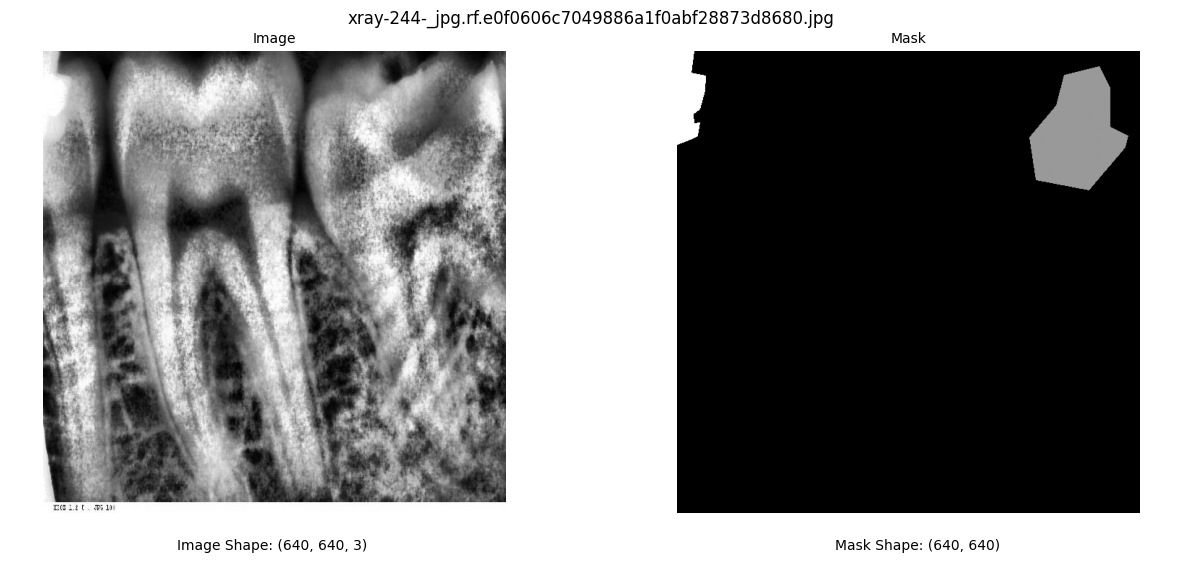

image bef:  (640, 640, 3)
image aft:  (640, 640, 3)


In [112]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)


image_idx = 45 # delete this

test_dataset.show_image_mask(image_idx)




# Load an image (This works far better if you don'd convert to a tensor first)
image_tensor = test_dataset[image_idx]["pixel_values"]

#image_tensor = torch.permute(image_tensor,(1,2,0)).numpy()


# image_tensor = torch.permute(image_tensor, (1,2,0))

# print("image fnl: ", image_tensor.size())




### SAM - Base model predictions (no grid):

In [96]:
# Load the SAM model
sam_checkpoint = "Models/sam_vit_l_0b3195.pth" 
sam_model = sam_model_registry["vit_l"](checkpoint=sam_checkpoint)
sam_model = sam_model.to("cuda")

# Initialize Automatic Mask Generator and generate mask
mask_generator = SamAutomaticMaskGenerator(sam_model)
masks = mask_generator.generate(image_tensor)


(640, 640, 3)


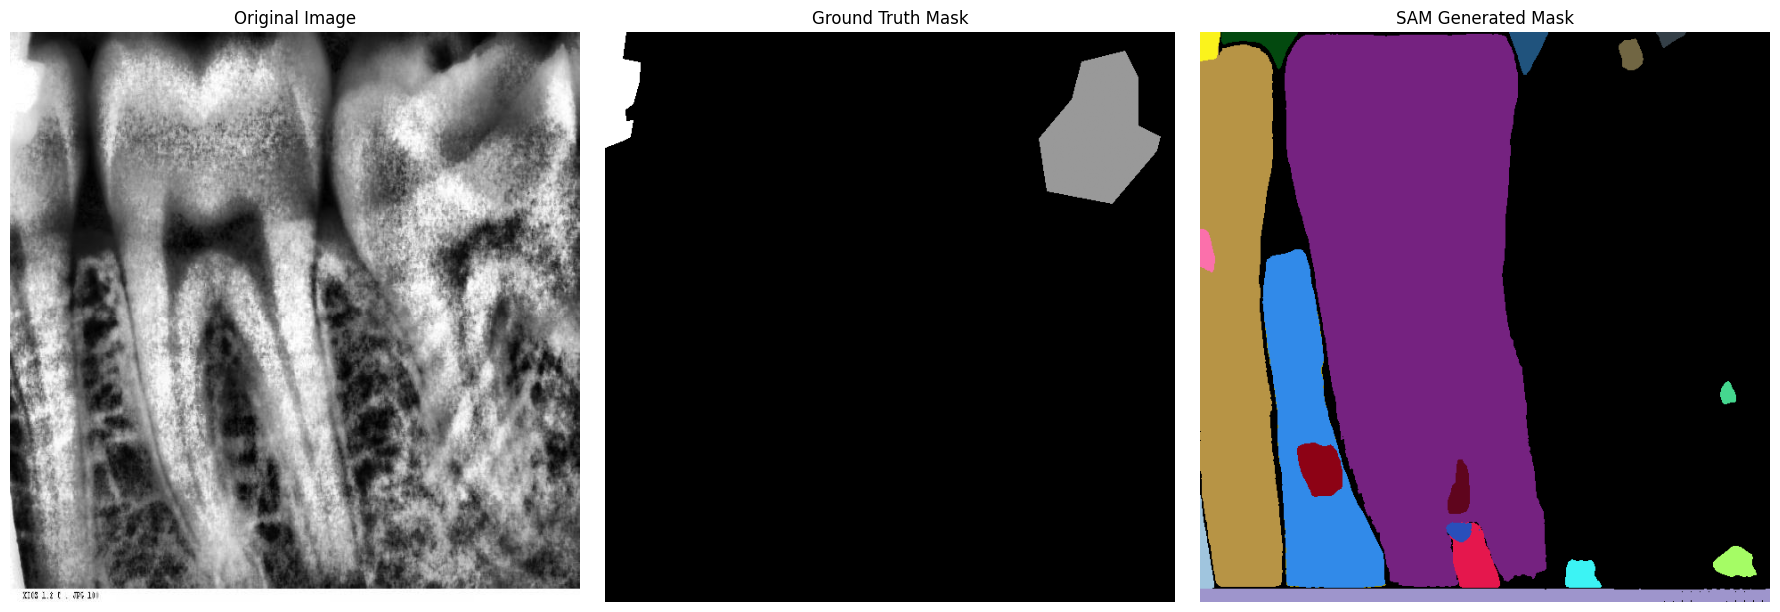

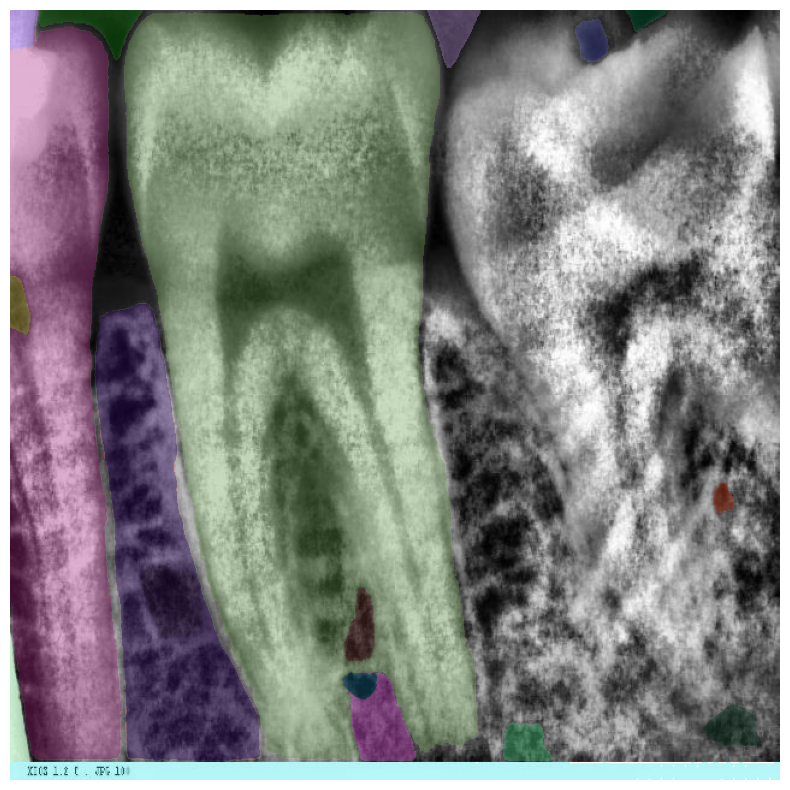

In [113]:

print(image_tensor.shape)



# Visualise Output
test_dataset.compare_image_masks(image_idx, masks)

test_dataset.show_anns(image_idx, masks)


### SAM - Base model predictions (grid of points):

In [114]:
image_np = image_tensor

# Create grid of points on image
height, width, _ = image_np.shape
num_points = 5  # 5*5 points

# Generate grid points
grid_points = []
for y in range(0, height, height // num_points):
    for x in range(0, width, width // num_points):
        grid_points.append([y, x])  # Each point is (x, y)

grid_points = np.array(grid_points)



# Initialize the SAM predictor
sam_predictor = SamPredictor(sam_model)

# Set the image once for the SAM predictor
sam_predictor.set_image(image_np)



# Function to generate mask for each point
def generate_mask_for_point(point):
    return sam_predictor.predict(point_coords=point[None, :], point_labels=np.array([1]))

# Use ThreadPoolExecutor to parallelize mask generation
with ThreadPoolExecutor() as executor:
    masks = list(executor.map(generate_mask_for_point, grid_points))

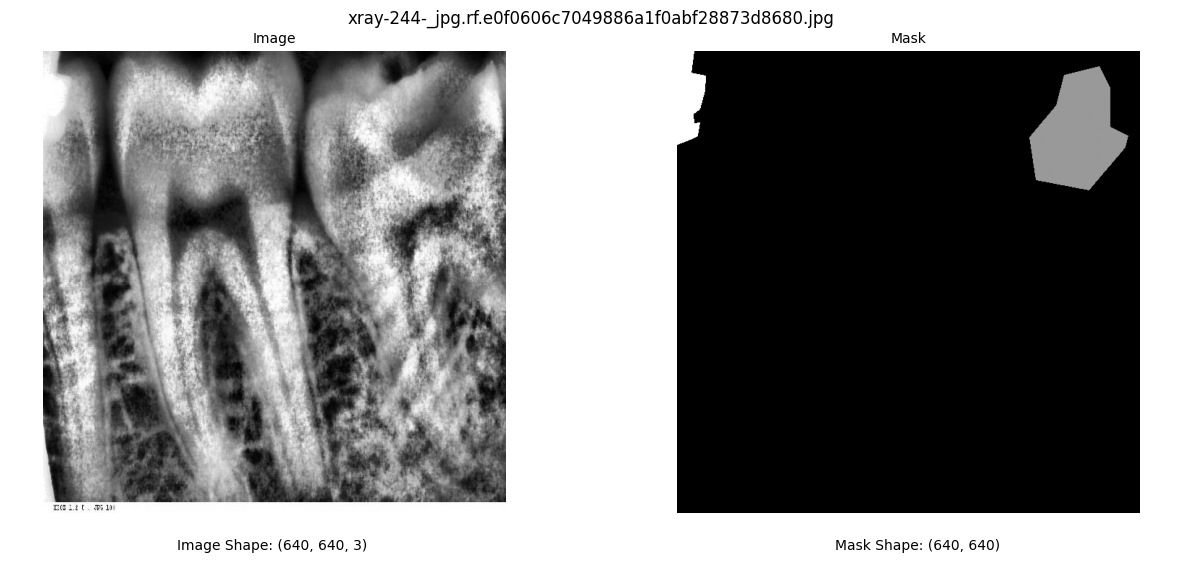

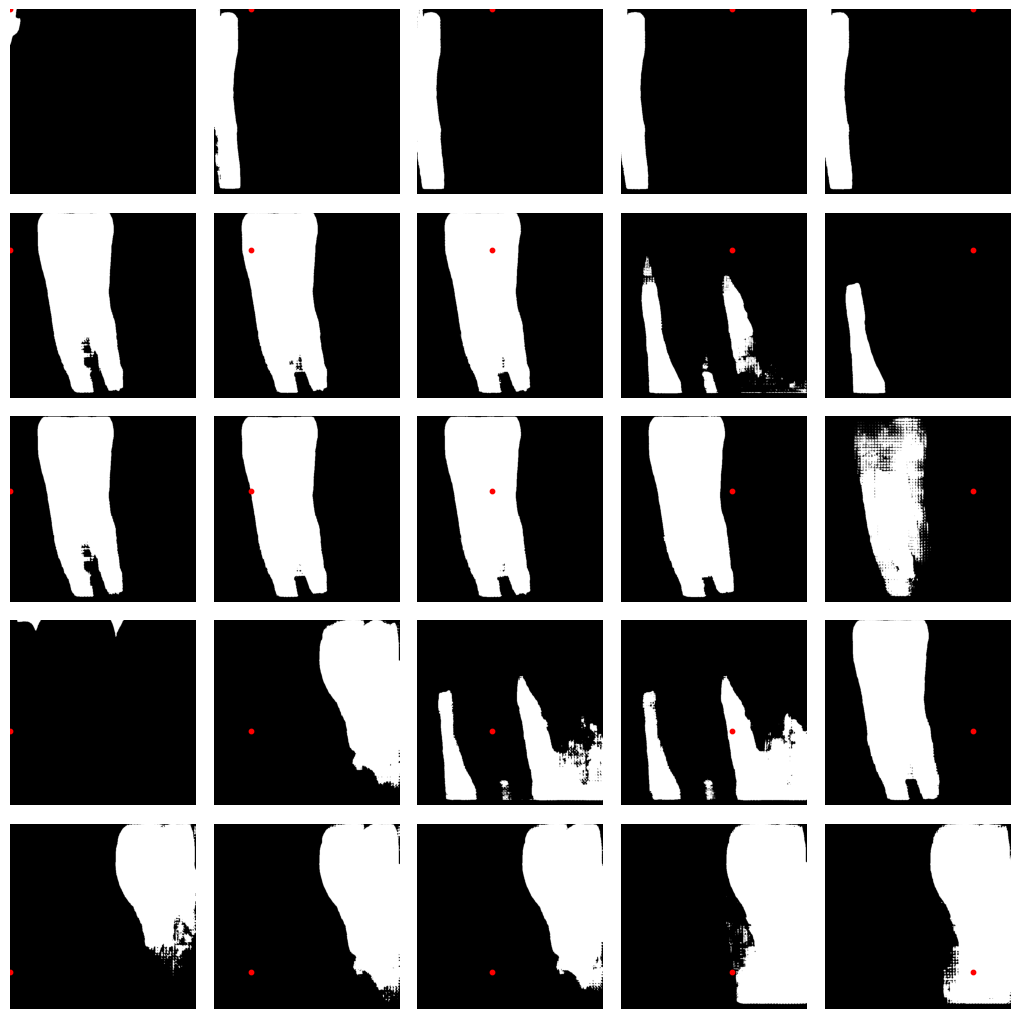

In [115]:
test_dataset.show_image_mask(image_idx)



fig, axes = plt.subplots(num_points, num_points, figsize=(10, 10))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of 2D grid

for i, (mask, point) in enumerate(zip(masks, grid_points)):
    mask_array = mask[0]

    # Ensure mask is 2D
    if mask_array.ndim > 2:
        mask_array = mask_array[0, :, :]

    # Display the mask
    axes[i].imshow(mask_array, cmap='gray')
    axes[i].axis("off")  # Remove axis

    # Plot the grid point as a red dot
    y, x = point 
    axes[i].scatter(x, y, color='red', s=10)  # Red dot at grid point


# Remove gaps
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()

## Model Evaluation

(640, 640, 3)   (640, 640, 1)


c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in '

{0: {'IoU': 0.9599121093749993, 'Precision': 1.0, 'Recall': 0.9599121093749993, 'F1 Score': 0.9782400579864223, 'Dice Score': 626.0736371113089, 'MCC': 0.0}}


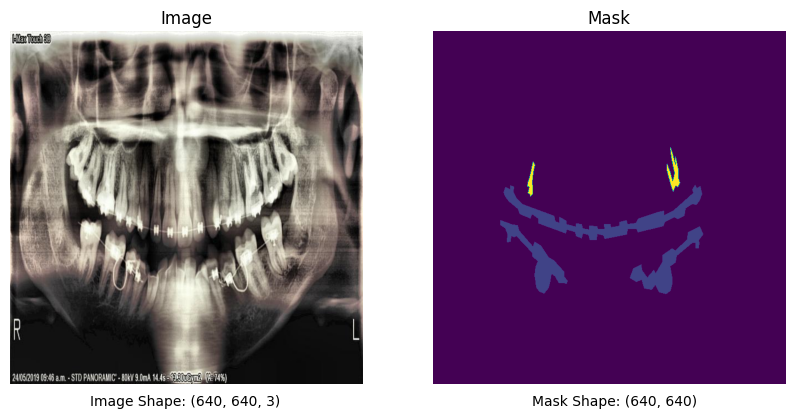

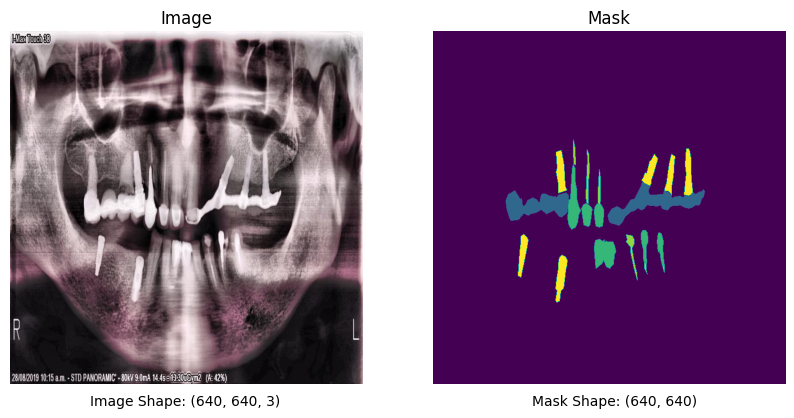

In [ ]:

# Example Usage:
# Load images (replace with your actual method)
image_tensor1, GT_mask1 = test_dataset[0]
image_tensor2, GT_mask2 = test_dataset[1]

# Convert image tensors (C, H, W) to (H, W, C) numpy arrays
image_np1 = image_tensor1.permute(1, 2, 0).numpy()
image_np2 = image_tensor2.permute(1, 2, 0).numpy()

GT_mask1 = GT_mask1.permute(1, 2, 0).numpy()
GT_mask2 = GT_mask2.permute(1, 2, 0).numpy()

# Now, pass them to the evaluator
masks = [image_np1, image_np2]  # Predicted masks (replace with your actual prediction)
gt_masks = [GT_mask1, GT_mask2]  # Ground truth masks

print(image_np1.shape, " " , GT_mask1.shape)

# Assuming model is initialized and passed to ModelEvaluator:
print(ModelEvaluator.evaluate_metrics(GT_mask1, GT_mask2))
test_dataset.show_image_mask(0)
test_dataset.show_image_mask(1)


# Fine-Tuning SAM

In [ ]:
# Ensure images are returned as preprocessed tensors
test_dataset.return_as_tensor = True

# Fetch a sample item
sample = test_dataset[0]
print(f"Sample keys: {sample.keys()}")
print(f"Sample pixel_values shape: {sample['pixel_values'].shape}")
print(f"Sample ground_truth_mask shape: {sample['ground_truth_mask'].shape}")

Sample keys: dict_keys(['pixel_values', 'ground_truth_mask'])
Sample pixel_values shape: (640, 640, 3)
Sample ground_truth_mask shape: (640, 640)


### Single class fine-tuning

### Setup SAM:

By default, SAM outputs binary masks. To enable multi-class segmentation we need to:
 - Change the output layer of the decoder to have C channels, where C = number of classes in your dataset.
 - Use softmax activation instead of sigmoid, so each pixel gets assigned a class probability.

In [183]:
import torch.nn as nn


# Load the SAM model
sam_checkpoint = "Models/sam_vit_l_0b3195.pth" 
sam_model = sam_model_registry["vit_l"](checkpoint=sam_checkpoint)
sam_model = sam_model.to("cuda")

# print(sam_model.mask_decoder)


# Modify SAM's mask decoder output MLPs
for mlp in sam_model.mask_decoder.output_hypernetworks_mlps:
    mlp.layers[-1] = nn.Linear(in_features=256, out_features=8, bias=True)  # Adjust output to 8 classes

# Modify SAM’s upsampling layer to output 8 channels instead of 4
sam_model.mask_decoder.output_upscaling.add_module(
    "final_conv", nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1)
)

In [184]:
import torch.nn.functional as F
from monai.losses import DiceLoss

def process_sam_output(logits):
    """
    Convert SAM logits to class index mask.
    """
    return torch.argmax(logits, dim=1)  # Shape: (B, H, W)

def one_hot_encode(mask, num_classes=8):
    """
    Convert class index mask to one-hot encoding.
    """
    return F.one_hot(mask, num_classes=num_classes).permute(0, 3, 1, 2).float()

def multi_class_loss(predictions, targets):
    """
    Compute multi-class segmentation loss (Cross-Entropy + Dice Loss).
    """
    ce_loss = F.cross_entropy(predictions, targets)  # Cross-entropy
    dice_loss = DiceLoss(to_onehot_y=True, softmax=True)(predictions, targets)  # Dice loss
    return ce_loss + dice_loss


In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

# Hyperparameters
batch_size = 2
num_epochs = 10
learning_rate = 1e-4

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)





# Optimizer and scheduler
optimizer = optim.AdamW(sam_model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # Reduce LR every 3 epochs

# Move model to GPU
sam_model.train()
sam_model = sam_model.to("cuda")

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    
    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()

        

        # Move inputs to GPU
        pixel_values = batch["pixel_values"].to("cuda")  # Shape: [B, 3, 1024, 1024]
        ground_truth_mask = batch["ground_truth_mask"].to("cuda")  # Shape: [B, H, W], values in [0-7]




        # print(sam_model)
        # print(pixel_values)
        print(pixel_values.shape)

        
        # Forward pass
        predictions = sam_model(pixel_values, multimask_output=False)["masks"]  # Shape: [B, 8, H, W]





        # Compute loss
        loss = multi_class_loss(predictions, ground_truth_mask)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Adjust learning rate
    scheduler.step()

    # Print training progress
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Save fine-tuned model
torch.save(sam_model.state_dict(), "Models/sam_vit_l_finetuned.pth")
print("Training complete. Model saved.")


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/850 [00:00<?, ?it/s]

torch.Size([2, 640, 640, 3])


IndexError: too many indices for tensor of dimension 3